In [1]:
import numpy as np
import pandas as pd
import warnings
import datetime
warnings.simplefilter('ignore')
import math
import time
from statistics import mean
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.metrics import mean_squared_error


#from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
import category_encoders as ce

import xgboost as xgb
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

In [2]:
status = pd.read_csv('../../../status.csv')

#statusのyear, month, dayを結合してdatetime型に
status['date'] = status['year'].astype(str) + '/' + status['month'].astype(str).str.zfill(2).astype(str) + '/' + status['day'].astype(str).str.zfill(2).astype(str) + '/' + status['hour'].astype(str).str.zfill(2).astype(str)
status['date'] = pd.to_datetime(status['date'], format='%Y/%m/%d/%H', infer_datetime_format=True)

#曜日を追加するための関数を定義
def get_weekday_jp(dt):
    w_list = ['月曜日', '火曜日', '水曜日', '木曜日', '金曜日', '土曜日', '日曜日']
    return(w_list[dt.weekday()])

#dateから曜日情報を取得
status["weekday"] = status["date"].apply(get_weekday_jp)

main_df = status[['date','hour', 'station_id', 'bikes_available', 'weekday', 'day']]

#カテゴリ変数をダミー変数化
main_df = pd.get_dummies(main_df)

In [3]:
stationid_set = [0, 15, 32, 36, 38, 40, 43, 49, 54, 56] 

In [6]:
for station_id in stationid_set:
    train_X = main_df[main_df['station_id'] == station_id]
    train_lag = train_X[train_X['date'] < '2013-10-01']['bikes_available']
    train_learn = train_X[train_X['date'] < '2013-10-01']
    train_learn = train_learn[train_learn['date'] >= '2013-09-02']
    
    i = 1
    while i < 25:
        row_name = "lag_" + str(i) + "hour"
        set = train_lag[24-i:720-i]
        train_learn[row_name] = set.values
        i += 1
    i = 0    
    
    train_learn_y = train_learn["bikes_available"]
    train_learn_x = train_learn.drop("station_id",axis=1)
    train_learn_x = train_learn_x.drop("date",axis=1)
    train_learn_x = train_learn_x.drop("bikes_available",axis=1)    

    reg_mod = xgb.XGBRegressor(objective='reg:squarederror',
        n_estimators=300,
        learning_rate=0.10,
        subsample=0.5,
        colsample_bytree=1, 
        max_depth=15,
    )
    reg_mod.fit(train_learn_x, train_learn_y) 
    predictions = reg_mod.predict(train_learn_x)
    train_learn['predict_24'] = predictions
    train_file_name = "xgb_24_predict/xgb_train_stationid" + str(station_id) + "_201309.csv" 
    train_learn.to_csv(train_file_name)
    
    test_lag = main_df[main_df['station_id'] == station_id][main_df['date'] < '2013-10-01']
    test_lag = test_lag[test_lag['date'] >= '2013-09-30']['bikes_available']     
    test = main_df[main_df['station_id'] == station_id][main_df['date'] < '2013-10-08']
    test = test[test['date'] >= '2013-10-01']
    test_y = test["bikes_available"]
    test_x = test.drop("station_id",axis=1)
    test_x = test_x.drop("date",axis=1)
    test_x = test_x.drop("bikes_available",axis=1)    

    pred_lightgbm_test = []
    len(pred_lightgbm_test)
    i=0
    while i < 168:
        test_x_line = test_x[i:i+1]

        lag = []
        for j in pred_lightgbm_test:
            lag.insert(0, j)

        for k in range(24 - len(pred_lightgbm_test)):
            lag.append(test_lag[23-k:24-k].values)
        s = 1
        while s < 25:
            row_name = "lag_" + str(s) + "hour"
            test_x_line[row_name] = lag[s-1]
            s += 1

        pred_lightgbm_test_lag_line = reg_mod.predict(test_x_line)
        pred_lightgbm_test =np.append(pred_lightgbm_test, pred_lightgbm_test_lag_line)
        i += 1

    test['predict_24'] = pred_lightgbm_test
    test_file_name = "xgb_24_predict/xgb_test_stationid" + str(station_id) + "_201309.csv" 
    test.to_csv(test_file_name)

In [7]:
for station_id in stationid_set:
    train_X = main_df[main_df['station_id'] == station_id]
    train_lag = train_X[train_X['date'] < '2014-02-01']
    train_lag = train_lag[train_lag['date'] >= '2014-01-01']['bikes_available']
    train_learn = train_X[train_X['date'] < '2014-02-01']
    train_learn = train_learn[train_learn['date'] >= '2014-01-02']
    
    i = 1
    while i < 25:
        row_name = "lag_" + str(i) + "hour"
        set = train_lag[24-i:744-i]
        train_learn[row_name] = set.values
        i += 1
    i = 0    
    
    train_learn_y = train_learn["bikes_available"]
    train_learn_x = train_learn.drop("station_id",axis=1)
    train_learn_x = train_learn_x.drop("date",axis=1)
    train_learn_x = train_learn_x.drop("bikes_available",axis=1)    

    reg_mod = xgb.XGBRegressor(objective='reg:squarederror',
        n_estimators=300,
        learning_rate=0.10,
        subsample=0.5,
        colsample_bytree=1, 
        max_depth=15,
    )
    reg_mod.fit(train_learn_x, train_learn_y) 
    predictions = reg_mod.predict(train_learn_x)
    train_learn['predict_24'] = predictions
    train_file_name = "xgb_24_predict/xgb_train_stationid" + str(station_id) + "_201401.csv" 
    train_learn.to_csv(train_file_name)
    
    test_lag = main_df[main_df['station_id'] == station_id][main_df['date'] < '2014-02-01']
    test_lag = test_lag[test_lag['date'] >= '2014-01-31']['bikes_available']     
    test = main_df[main_df['station_id'] == station_id][main_df['date'] < '2014-02-08']
    test = test[test['date'] >= '2014-02-01']
    test_y = test["bikes_available"]
    test_x = test.drop("station_id",axis=1)
    test_x = test_x.drop("date",axis=1)
    test_x = test_x.drop("bikes_available",axis=1)    

    pred_lightgbm_test = []
    len(pred_lightgbm_test)
    i=0
    while i < 168:
        test_x_line = test_x[i:i+1]

        lag = []
        for j in pred_lightgbm_test:
            lag.insert(0, j)

        for k in range(24 - len(pred_lightgbm_test)):
            lag.append(test_lag[23-k:24-k].values)
        s = 1
        while s < 25:
            row_name = "lag_" + str(s) + "hour"
            test_x_line[row_name] = lag[s-1]
            s += 1

        pred_lightgbm_test_lag_line = reg_mod.predict(test_x_line)
        pred_lightgbm_test =np.append(pred_lightgbm_test, pred_lightgbm_test_lag_line)
        i += 1

    test['predict_24'] = pred_lightgbm_test
    test_file_name = "xgb_24_predict/xgb_test_stationid" + str(station_id) + "_201401.csv" 
    test.to_csv(test_file_name)

In [8]:
for station_id in stationid_set:
    train_X = main_df[main_df['station_id'] == station_id]
    train_lag = train_X[train_X['date'] < '2014-06-01']
    train_lag = train_lag[train_lag['date'] >= '2014-05-01']['bikes_available']
    train_learn = train_X[train_X['date'] < '2014-06-01']
    train_learn = train_learn[train_learn['date'] >= '2014-05-02']
    
    i = 1
    while i < 25:
        row_name = "lag_" + str(i) + "hour"
        set = train_lag[24-i:744-i]
        train_learn[row_name] = set.values
        i += 1
    i = 0    
    
    train_learn_y = train_learn["bikes_available"]
    train_learn_x = train_learn.drop("station_id",axis=1)
    train_learn_x = train_learn_x.drop("date",axis=1)
    train_learn_x = train_learn_x.drop("bikes_available",axis=1)    


    reg_mod = xgb.XGBRegressor(objective='reg:squarederror',
        n_estimators=300,
        learning_rate=0.10,
        subsample=0.5,
        colsample_bytree=1, 
        max_depth=15,
    )
    reg_mod.fit(train_learn_x, train_learn_y) 
    predictions = reg_mod.predict(train_learn_x)
    train_learn['predict_24'] = predictions
    train_file_name = "xgb_24_predict/xgb_train_stationid" + str(station_id) + "_201405.csv" 
    train_learn.to_csv(train_file_name)
    
    test_lag = main_df[main_df['station_id'] == station_id][main_df['date'] < '2014-06-01']
    test_lag = test_lag[test_lag['date'] >= '2014-05-31']['bikes_available']     
    test = main_df[main_df['station_id'] == station_id][main_df['date'] < '2014-06-08']
    test = test[test['date'] >= '2014-06-01']
    test_y = test["bikes_available"]
    test_x = test.drop("station_id",axis=1)
    test_x = test_x.drop("date",axis=1)
    test_x = test_x.drop("bikes_available",axis=1)    

    pred_lightgbm_test = []
    len(pred_lightgbm_test)
    i=0
    while i < 168:
        test_x_line = test_x[i:i+1]

        lag = []
        for j in pred_lightgbm_test:
            lag.insert(0, j)

        for k in range(24 - len(pred_lightgbm_test)):
            lag.append(test_lag[23-k:24-k].values)
        s = 1
        while s < 25:
            row_name = "lag_" + str(s) + "hour"
            test_x_line[row_name] = lag[s-1]
            s += 1

        pred_lightgbm_test_lag_line = reg_mod.predict(test_x_line)
        pred_lightgbm_test =np.append(pred_lightgbm_test, pred_lightgbm_test_lag_line)
        i += 1

    test['predict_24'] = pred_lightgbm_test
    test_file_name = "xgb_24_predict/xgb_test_stationid" + str(station_id) + "_201405.csv" 
    test.to_csv(test_file_name)

[0]	train-rmse:9.23836	valid-rmse:8.92685
[50]	train-rmse:0.14937	valid-rmse:1.43939
[100]	train-rmse:0.03177	valid-rmse:1.44173
[150]	train-rmse:0.00882	valid-rmse:1.45580
[200]	train-rmse:0.00286	valid-rmse:1.45704
[250]	train-rmse:0.00189	valid-rmse:1.45729
[299]	train-rmse:0.00189	valid-rmse:1.45729
elapsed_time:0.3070685863494873[sec]


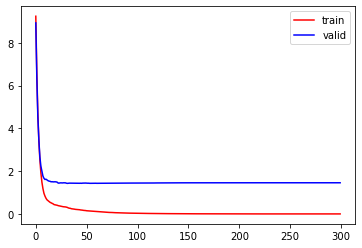

In [9]:
stationid_set =[0]
start = time.time()
for station_id in stationid_set:
    train_X = main_df[main_df['station_id'] == station_id]
    train_lag = train_X[train_X['date'] < '2013-10-01']['bikes_available']
    train_learn = train_X[train_X['date'] < '2013-10-01']
    train_learn = train_learn[train_learn['date'] >= '2013-09-02']
    
    i = 1
    while i < 25:
        row_name = "lag_" + str(i) + "hour"
        set = train_lag[24-i:720-i]
        train_learn[row_name] = set.values
        i += 1
    i = 0    
    
    train_learn_y = train_learn["bikes_available"][train_learn['date'] < '2013-09-28']
    train_learn_x = train_learn[train_learn['date'] < '2013-09-28'].drop("station_id",axis=1)
    train_learn_x = train_learn_x.drop("date",axis=1)
    train_learn_x = train_learn_x.drop("bikes_available",axis=1)    
    
    test_y = train_learn["bikes_available"][train_learn['date'] >= '2013-09-28']
    test_x = train_learn[train_learn['date'] >= '2013-09-28'].drop("station_id",axis=1)
    test_x = test_x.drop("date",axis=1)
    test_x = test_x.drop("bikes_available",axis=1)     
    
    
    dtrain = xgb.DMatrix(train_learn_x, label=train_learn_y)
    dvalid = xgb.DMatrix(test_x, test_y)
    params = {
        "objective" : "reg:squarederror",
        "eval_metric" : "rmse"
    }    
    
    dtrain = xgb.DMatrix(train_learn_x, train_learn_y)
    results_dict = {}
    model = xgb.train(
        params = params,
        dtrain =  dtrain,
        evals = [(dtrain, "train"), (dvalid, "valid")],
        num_boost_round = 300,
        verbose_eval=50,
        evals_result = results_dict
    )
    elapsed_time = time.time() - start
    print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")
    plt.plot(results_dict["train"]["rmse"], color = "red", label = "train")
    plt.plot(results_dict["valid"]["rmse"], color = "blue", label = "valid")
    plt.legend()
    plt.show()

[0]	train-rmse:9.33867
[50]	train-rmse:0.30119
[100]	train-rmse:0.11577
[150]	train-rmse:0.05795
[200]	train-rmse:0.03102
[250]	train-rmse:0.01712
[299]	train-rmse:0.01030


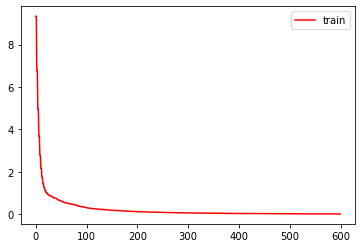

elapsed_time:0.414093017578125[sec]
[0]	train-rmse:8.22740
[50]	train-rmse:0.10080
[100]	train-rmse:0.03338
[150]	train-rmse:0.01550
[200]	train-rmse:0.00819
[250]	train-rmse:0.00819
[299]	train-rmse:0.00819


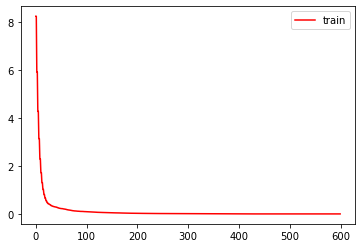

elapsed_time:0.3310739994049072[sec]
[0]	train-rmse:4.89591
[50]	train-rmse:0.35790
[100]	train-rmse:0.14817
[150]	train-rmse:0.06574
[200]	train-rmse:0.03249
[250]	train-rmse:0.01594
[299]	train-rmse:0.00961


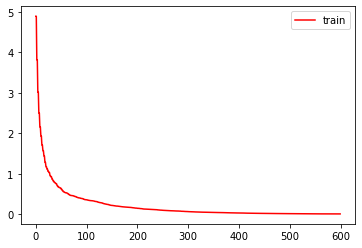

elapsed_time:0.3900883197784424[sec]
[0]	train-rmse:5.63293
[50]	train-rmse:0.36041
[100]	train-rmse:0.13476
[150]	train-rmse:0.05994
[200]	train-rmse:0.03159
[250]	train-rmse:0.01603
[299]	train-rmse:0.01238


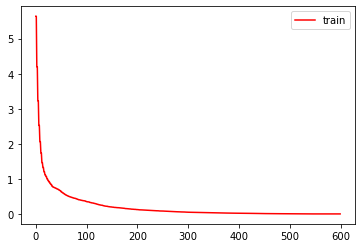

elapsed_time:0.3920872211456299[sec]
[0]	train-rmse:7.19664
[50]	train-rmse:0.44625
[100]	train-rmse:0.18519
[150]	train-rmse:0.08328
[200]	train-rmse:0.04307
[250]	train-rmse:0.02202
[299]	train-rmse:0.01233


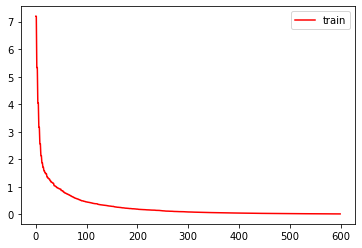

elapsed_time:0.42009472846984863[sec]
[0]	train-rmse:5.59501
[50]	train-rmse:0.37948
[100]	train-rmse:0.13873
[150]	train-rmse:0.06010
[200]	train-rmse:0.02952
[250]	train-rmse:0.01527
[299]	train-rmse:0.01280


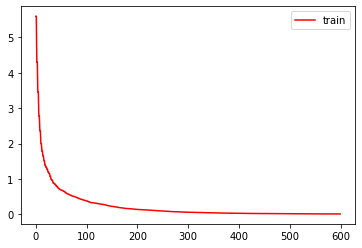

elapsed_time:0.40809106826782227[sec]
[0]	train-rmse:6.80206
[50]	train-rmse:0.40650
[100]	train-rmse:0.16411
[150]	train-rmse:0.07888
[200]	train-rmse:0.03938
[250]	train-rmse:0.02033
[299]	train-rmse:0.01056


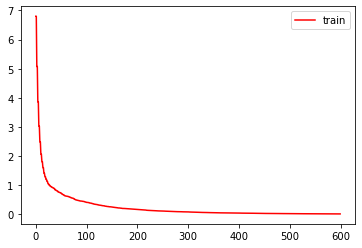

elapsed_time:0.40909242630004883[sec]
[0]	train-rmse:8.46528
[50]	train-rmse:0.53564
[100]	train-rmse:0.23204
[150]	train-rmse:0.10965
[200]	train-rmse:0.05964
[250]	train-rmse:0.03308
[299]	train-rmse:0.01936


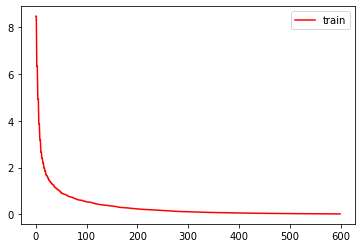

elapsed_time:0.438098669052124[sec]
[0]	train-rmse:7.91691
[50]	train-rmse:0.41344
[100]	train-rmse:0.15952
[150]	train-rmse:0.07215
[200]	train-rmse:0.03795
[250]	train-rmse:0.01988
[299]	train-rmse:0.01135


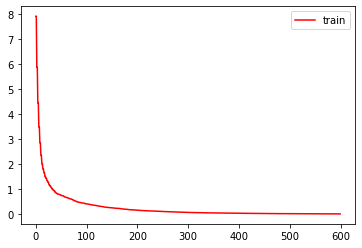

elapsed_time:0.48210787773132324[sec]
[0]	train-rmse:6.77909
[50]	train-rmse:0.30887
[100]	train-rmse:0.11658
[150]	train-rmse:0.05420
[200]	train-rmse:0.02592
[250]	train-rmse:0.01180
[299]	train-rmse:0.00927


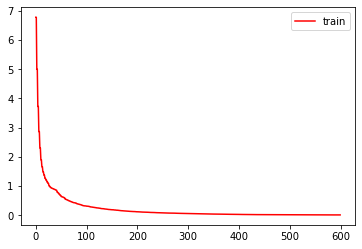

elapsed_time:0.3940894603729248[sec]


In [12]:
for station_id in stationid_set:
    start = time.time()
    train_X = main_df[main_df['station_id'] == station_id]
    train_learn = train_X[train_X['date'] < '2013-10-01']
    train_learn = train_learn[train_learn['date'] >= '2013-09-02']
    train_learn_y = train_learn["bikes_available"]
    train_learn_x = train_learn.drop("station_id",axis=1)
    train_learn_x = train_learn_x.drop("date",axis=1)
    train_learn_x = train_learn_x.drop("bikes_available",axis=1)    

    dtrain = xgb.DMatrix(train_learn_x, label=train_learn_y)
    params = {
        "objective" : "reg:squarederror",
        "eval_metric" : "rmse"
    }        
    dtrain = xgb.DMatrix(train_learn_x, train_learn_y)
    results_dict = {}
    model = xgb.train(
        params = params,
        dtrain =  dtrain,
        evals = [(dtrain, "train"), (dtrain, "train")],
        num_boost_round = 300,
        verbose_eval=50,
        evals_result = results_dict
    )
    plt.plot(results_dict["train"]["rmse"], color = "red", label = "train")
    plt.legend()
    plt.show()
    
    predictions = model.predict(xgb.DMatrix(train_learn_x))
    train_learn['predict_24'] = predictions
    train_file_name = "xgb_24_predict/nomal/xgb_train_stationid" + str(station_id) + "_201309.csv" 
    train_learn.to_csv(train_file_name)
      
    test = main_df[main_df['station_id'] == station_id][main_df['date'] < '2013-10-08']
    test = test[test['date'] >= '2013-10-01']
    test_y = test["bikes_available"]
    test_x = test.drop("station_id",axis=1)
    test_x = test_x.drop("date",axis=1)
    test_x = test_x.drop("bikes_available",axis=1)    
    
    pred_lightgbm_test = model.predict(xgb.DMatrix(test_x))
    test['predict_24'] = pred_lightgbm_test
    test_file_name = "xgb_24_predict/nomal/xgb_test_stationid" + str(station_id) + "_201309.csv" 
    test.to_csv(test_file_name)
    elapsed_time = time.time() - start
    print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

In [13]:
for station_id in stationid_set:
    train_X = main_df[main_df['station_id'] == station_id]
    train_learn = train_X[train_X['date'] < '2014-02-01']
    train_learn = train_learn[train_learn['date'] >= '2014-01-02']
    train_learn_y = train_learn["bikes_available"]
    train_learn_x = train_learn.drop("station_id",axis=1)
    train_learn_x = train_learn_x.drop("date",axis=1)
    train_learn_x = train_learn_x.drop("bikes_available",axis=1)    

    dtrain = xgb.DMatrix(train_learn_x, label=train_learn_y)
    params = {
        "objective" : "reg:squarederror",
        "eval_metric" : "rmse"
    }        
    dtrain = xgb.DMatrix(train_learn_x, train_learn_y)
    results_dict = {}
    model = xgb.train(
        params = params,
        dtrain =  dtrain,
        evals = [(dtrain, "train"), (dtrain, "train")],
        num_boost_round = 300,
        verbose_eval=50,
        evals_result = results_dict
    )
    predictions = model.predict(xgb.DMatrix(train_learn_x))
    train_learn['predict_24'] = predictions
    train_file_name = "xgb_24_predict/nomal/xgb_train_stationid" + str(station_id) + "_201401.csv" 
    train_learn.to_csv(train_file_name)
    
    test = main_df[main_df['station_id'] == station_id][main_df['date'] < '2014-02-08']
    test = test[test['date'] >= '2014-02-01']
    test_y = test["bikes_available"]
    test_x = test.drop("station_id",axis=1)
    test_x = test_x.drop("date",axis=1)
    test_x = test_x.drop("bikes_available",axis=1)    

    pred_lightgbm_test = model.predict(xgb.DMatrix(test_x))
    test['predict_24'] = pred_lightgbm_test
    test_file_name = "xgb_24_predict/nomal/xgb_test_stationid" + str(station_id) + "_201401.csv" 
    test.to_csv(test_file_name)

[0]	train-rmse:9.53319
[50]	train-rmse:0.31960
[100]	train-rmse:0.14250
[150]	train-rmse:0.07535
[200]	train-rmse:0.04085
[250]	train-rmse:0.02190
[299]	train-rmse:0.01331
[0]	train-rmse:9.63221
[50]	train-rmse:0.07797
[100]	train-rmse:0.02079
[150]	train-rmse:0.00852
[200]	train-rmse:0.00742
[250]	train-rmse:0.00742
[299]	train-rmse:0.00742
[0]	train-rmse:5.42178
[50]	train-rmse:0.33375
[100]	train-rmse:0.14614
[150]	train-rmse:0.06907
[200]	train-rmse:0.03471
[250]	train-rmse:0.01987
[299]	train-rmse:0.01288
[0]	train-rmse:6.01459
[50]	train-rmse:0.32872
[100]	train-rmse:0.12719
[150]	train-rmse:0.06508
[200]	train-rmse:0.03459
[250]	train-rmse:0.01847
[299]	train-rmse:0.01172
[0]	train-rmse:6.73494
[50]	train-rmse:0.41653
[100]	train-rmse:0.19359
[150]	train-rmse:0.09529
[200]	train-rmse:0.04902
[250]	train-rmse:0.02857
[299]	train-rmse:0.01611
[0]	train-rmse:6.77320
[50]	train-rmse:0.42456
[100]	train-rmse:0.18255
[150]	train-rmse:0.09249
[200]	train-rmse:0.05055
[250]	train-rmse:0

In [14]:
start = time.time()
for station_id in stationid_set:
    train_X = main_df[main_df['station_id'] == station_id]
    train_learn = train_X[train_X['date'] < '2014-06-01']
    train_learn = train_learn[train_learn['date'] >= '2014-05-02']
    train_learn_y = train_learn["bikes_available"]
    train_learn_x = train_learn.drop("station_id",axis=1)
    train_learn_x = train_learn_x.drop("date",axis=1)
    train_learn_x = train_learn_x.drop("bikes_available",axis=1)    

    dtrain = xgb.DMatrix(train_learn_x, label=train_learn_y)
    params = {
        "objective" : "reg:squarederror",
        "eval_metric" : "rmse"
    }        
    dtrain = xgb.DMatrix(train_learn_x, train_learn_y)
    results_dict = {}
    model = xgb.train(
        params = params,
        dtrain =  dtrain,
        evals = [(dtrain, "train"), (dtrain, "train")],
        num_boost_round = 300,
        verbose_eval=50,
        evals_result = results_dict
    )
    predictions = model.predict(xgb.DMatrix(train_learn_x))
    train_learn['predict_24'] = predictions
    train_file_name = "xgb_24_predict/nomal/xgb_train_stationid" + str(station_id) + "_201405.csv" 
    train_learn.to_csv(train_file_name)
    
    test = main_df[main_df['station_id'] == station_id][main_df['date'] < '2014-06-08']
    test = test[test['date'] >= '2014-06-01']
    test_y = test["bikes_available"]
    test_x = test.drop("station_id",axis=1)
    test_x = test_x.drop("date",axis=1)
    test_x = test_x.drop("bikes_available",axis=1)    

    pred_lightgbm_test = model.predict(xgb.DMatrix(test_x))
    test['predict_24'] = pred_lightgbm_test
    test_file_name = "xgb_24_predict/nomal/xgb_test_stationid" + str(station_id) + "_201405.csv" 
    test.to_csv(test_file_name)
elapsed_time = time.time() - start
print(elapsed_time)

[0]	train-rmse:9.43522
[50]	train-rmse:0.38637
[100]	train-rmse:0.17145
[150]	train-rmse:0.08100
[200]	train-rmse:0.04312
[250]	train-rmse:0.02283
[299]	train-rmse:0.01367
[0]	train-rmse:9.35455
[50]	train-rmse:0.12552
[100]	train-rmse:0.05005
[150]	train-rmse:0.02309
[200]	train-rmse:0.01302
[250]	train-rmse:0.01302
[299]	train-rmse:0.01302
[0]	train-rmse:4.91416
[50]	train-rmse:0.29794
[100]	train-rmse:0.12881
[150]	train-rmse:0.06253
[200]	train-rmse:0.03241
[250]	train-rmse:0.01589
[299]	train-rmse:0.00982
[0]	train-rmse:4.88771
[50]	train-rmse:0.30427
[100]	train-rmse:0.12745
[150]	train-rmse:0.05266
[200]	train-rmse:0.02559
[250]	train-rmse:0.01212
[299]	train-rmse:0.00995
[0]	train-rmse:5.90085
[50]	train-rmse:0.38261
[100]	train-rmse:0.15448
[150]	train-rmse:0.07598
[200]	train-rmse:0.03950
[250]	train-rmse:0.02314
[299]	train-rmse:0.01204
[0]	train-rmse:5.79871
[50]	train-rmse:0.43538
[100]	train-rmse:0.17184
[150]	train-rmse:0.08731
[200]	train-rmse:0.04815
[250]	train-rmse:0

[0]	train-rmse:9.33867
[50]	train-rmse:0.30119
[100]	train-rmse:0.11577
[150]	train-rmse:0.05795
[200]	train-rmse:0.03102
[250]	train-rmse:0.01712
[299]	train-rmse:0.01030


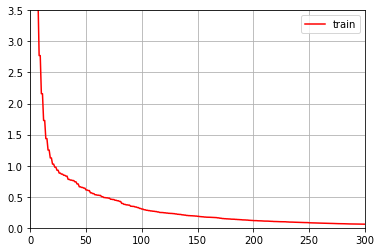

elapsed_time:0.4000885486602783[sec]
[0]	train-rmse:8.22740
[50]	train-rmse:0.10080
[100]	train-rmse:0.03338
[150]	train-rmse:0.01550
[200]	train-rmse:0.00819
[250]	train-rmse:0.00819
[299]	train-rmse:0.00819


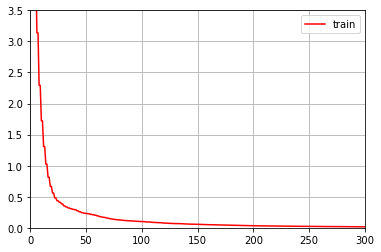

elapsed_time:0.3380753993988037[sec]
[0]	train-rmse:4.89591
[50]	train-rmse:0.35790
[100]	train-rmse:0.14817
[150]	train-rmse:0.06574
[200]	train-rmse:0.03249
[250]	train-rmse:0.01594
[299]	train-rmse:0.00961


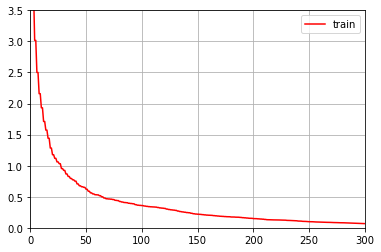

elapsed_time:0.41309237480163574[sec]
[0]	train-rmse:5.63293
[50]	train-rmse:0.36041
[100]	train-rmse:0.13476
[150]	train-rmse:0.05994
[200]	train-rmse:0.03159
[250]	train-rmse:0.01603
[299]	train-rmse:0.01238


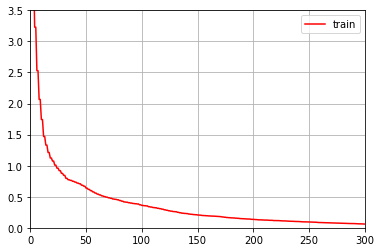

elapsed_time:0.4140925407409668[sec]
[0]	train-rmse:7.19664
[50]	train-rmse:0.44625
[100]	train-rmse:0.18519
[150]	train-rmse:0.08328
[200]	train-rmse:0.04307
[250]	train-rmse:0.02202
[299]	train-rmse:0.01233


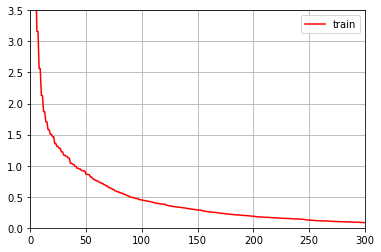

elapsed_time:0.41309237480163574[sec]
[0]	train-rmse:5.59501
[50]	train-rmse:0.37948
[100]	train-rmse:0.13873
[150]	train-rmse:0.06010
[200]	train-rmse:0.02952
[250]	train-rmse:0.01527
[299]	train-rmse:0.01280


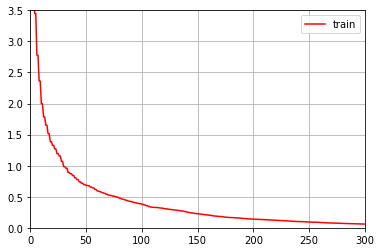

elapsed_time:0.43709778785705566[sec]
[0]	train-rmse:6.80206
[50]	train-rmse:0.40650
[100]	train-rmse:0.16411
[150]	train-rmse:0.07888
[200]	train-rmse:0.03938
[250]	train-rmse:0.02033
[299]	train-rmse:0.01056


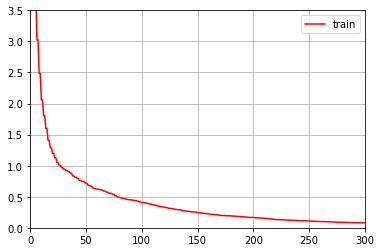

elapsed_time:0.4140925407409668[sec]
[0]	train-rmse:8.46528
[50]	train-rmse:0.53564
[100]	train-rmse:0.23204
[150]	train-rmse:0.10965
[200]	train-rmse:0.05964
[250]	train-rmse:0.03308
[299]	train-rmse:0.01936


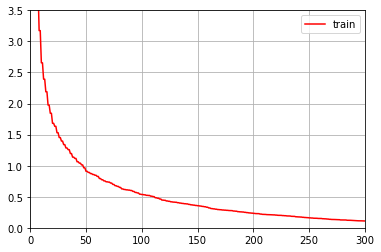

elapsed_time:0.42409491539001465[sec]
[0]	train-rmse:7.91691
[50]	train-rmse:0.41344
[100]	train-rmse:0.15952
[150]	train-rmse:0.07215
[200]	train-rmse:0.03795
[250]	train-rmse:0.01988
[299]	train-rmse:0.01135


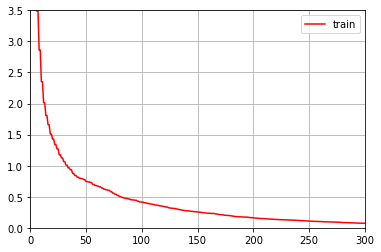

elapsed_time:0.4010891914367676[sec]
[0]	train-rmse:6.77909
[50]	train-rmse:0.30887
[100]	train-rmse:0.11658
[150]	train-rmse:0.05420
[200]	train-rmse:0.02592
[250]	train-rmse:0.01180
[299]	train-rmse:0.00927


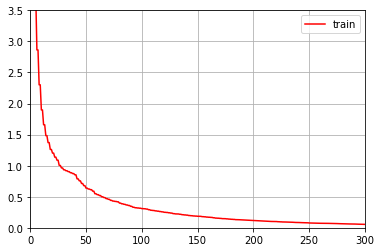

elapsed_time:0.3940877914428711[sec]


In [17]:
for station_id in stationid_set:
    start = time.time()
    train_X = main_df[main_df['station_id'] == station_id]
    train_learn = train_X[train_X['date'] < '2013-10-01']
    train_learn = train_learn[train_learn['date'] >= '2013-09-02']
    train_learn_y = train_learn["bikes_available"]
    train_learn_x = train_learn.drop("station_id",axis=1)
    train_learn_x = train_learn_x.drop("date",axis=1)
    train_learn_x = train_learn_x.drop("bikes_available",axis=1)    

    dtrain = xgb.DMatrix(train_learn_x, label=train_learn_y)
    params = {
        "objective" : "reg:squarederror",
        "eval_metric" : "rmse"
    }        
    dtrain = xgb.DMatrix(train_learn_x, train_learn_y)
    results_dict = {}
    model = xgb.train(
        params = params,
        dtrain =  dtrain,
        evals = [(dtrain, "train"), (dtrain, "train")],
        num_boost_round = 300,
        verbose_eval=50,
        evals_result = results_dict
    )
    plt.plot(results_dict["train"]["rmse"], color = "red", label = "train")
    plt.xlim([0,300])
    plt.ylim([0,3.5])
    plt.grid()
    plt.legend()
    plt.show()
    
    predictions = model.predict(xgb.DMatrix(train_learn_x))
    train_learn['predict_24'] = predictions
    train_file_name = "xgb_24_predict/nomal/xgb_train_stationid" + str(station_id) + "_201309.csv" 
    train_learn.to_csv(train_file_name)
      
    test = main_df[main_df['station_id'] == station_id][main_df['date'] < '2013-10-08']
    test = test[test['date'] >= '2013-10-01']
    test_y = test["bikes_available"]
    test_x = test.drop("station_id",axis=1)
    test_x = test_x.drop("date",axis=1)
    test_x = test_x.drop("bikes_available",axis=1)    
    
    pred_lightgbm_test = model.predict(xgb.DMatrix(test_x))
    test['predict_24'] = pred_lightgbm_test
    test_file_name = "xgb_24_predict/nomal/xgb_test_stationid" + str(station_id) + "_201309.csv" 
    test.to_csv(test_file_name)
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

In [6]:
#回帰分析2013年10月時間計測
start = time.time()
for station_id in stationid_set:
    train_X = main_df[main_df['station_id'] == station_id]
    train_learn = train_X[train_X['date'] < '2013-10-01']
    train_learn = train_learn[train_learn['date'] >= '2013-09-02']
    train_learn_y = train_learn["bikes_available"]
    train_learn_x = train_learn.drop("station_id",axis=1)
    train_learn_x = train_learn_x.drop("date",axis=1)
    train_learn_x = train_learn_x.drop("bikes_available",axis=1)    

    dtrain = xgb.DMatrix(train_learn_x, label=train_learn_y)
    params = {
        "objective" : "reg:squarederror",
        "eval_metric" : "rmse"
    }        
    dtrain = xgb.DMatrix(train_learn_x, train_learn_y)
    results_dict = {}
    model = xgb.train(
        params = params,
        dtrain =  dtrain,
        evals = [(dtrain, "train"), (dtrain, "train")],
        num_boost_round = 300,
        verbose_eval=50,
        evals_result = results_dict
    )
#     plt.plot(results_dict["train"]["rmse"], color = "red", label = "train")
#     plt.xlim([0,300])
#     plt.ylim([0,3.5])
#     plt.grid()
#     plt.legend()
#     plt.show()
    
    predictions = model.predict(xgb.DMatrix(train_learn_x))
#     train_learn['predict_24'] = predictions
#     train_file_name = "xgb_24_predict/nomal/xgb_train_stationid" + str(station_id) + "_201309.csv" 
#     train_learn.to_csv(train_file_name)
      
    test = main_df[main_df['station_id'] == station_id][main_df['date'] < '2013-10-08']
    test = test[test['date'] >= '2013-10-01']
    test_y = test["bikes_available"]
    test_x = test.drop("station_id",axis=1)
    test_x = test_x.drop("date",axis=1)
    test_x = test_x.drop("bikes_available",axis=1)    
    
    pred_lightgbm_test = model.predict(xgb.DMatrix(test_x))
#     test['predict_24'] = pred_lightgbm_test
#     test_file_name = "xgb_24_predict/nomal/xgb_test_stationid" + str(station_id) + "_201309.csv" 
#     test.to_csv(test_file_name)
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

[0]	train-rmse:9.33867
[50]	train-rmse:0.30119
[100]	train-rmse:0.11577
[150]	train-rmse:0.05795
[200]	train-rmse:0.03102
[250]	train-rmse:0.01712
[299]	train-rmse:0.01030
[0]	train-rmse:8.22740
[50]	train-rmse:0.10080
[100]	train-rmse:0.03338
[150]	train-rmse:0.01550
[200]	train-rmse:0.00819
[250]	train-rmse:0.00819
[299]	train-rmse:0.00819
[0]	train-rmse:4.89591
[50]	train-rmse:0.35790
[100]	train-rmse:0.14817
[150]	train-rmse:0.06574
[200]	train-rmse:0.03249
[250]	train-rmse:0.01594
[299]	train-rmse:0.00961
[0]	train-rmse:5.63293
[50]	train-rmse:0.36041
[100]	train-rmse:0.13476
[150]	train-rmse:0.05994
[200]	train-rmse:0.03159
[250]	train-rmse:0.01603
[299]	train-rmse:0.01238
[0]	train-rmse:7.19664
[50]	train-rmse:0.44625
[100]	train-rmse:0.18519
[150]	train-rmse:0.08328
[200]	train-rmse:0.04307
[250]	train-rmse:0.02202
[299]	train-rmse:0.01233
[0]	train-rmse:5.59501
[50]	train-rmse:0.37948
[100]	train-rmse:0.13873
[150]	train-rmse:0.06010
[200]	train-rmse:0.02952
[250]	train-rmse:0

In [5]:
#ラグ変数あり2013年10月時間計測
start = time.time()
for station_id in stationid_set:
    train_X = main_df[main_df['station_id'] == station_id]
    train_lag = train_X[train_X['date'] < '2013-10-01']['bikes_available']
    train_learn = train_X[train_X['date'] < '2013-10-01']
    train_learn = train_learn[train_learn['date'] >= '2013-09-02']
    
    i = 1
    while i < 25:
        row_name = "lag_" + str(i) + "hour"
        set = train_lag[24-i:720-i]
        train_learn[row_name] = set.values
        i += 1
    i = 0    
    
    train_learn_y = train_learn["bikes_available"]
    train_learn_x = train_learn.drop("station_id",axis=1)
    train_learn_x = train_learn_x.drop("date",axis=1)
    train_learn_x = train_learn_x.drop("bikes_available",axis=1)    

    reg_mod = xgb.XGBRegressor(objective='reg:squarederror',
        n_estimators=300,
        learning_rate=0.10,
        subsample=0.5,
        colsample_bytree=1, 
        max_depth=15,
    )
    reg_mod.fit(train_learn_x, train_learn_y) 
    predictions = reg_mod.predict(train_learn_x)
    train_learn['predict_24'] = predictions
    train_file_name = "xgb_24_predict/xgb_train_stationid" + str(station_id) + "_201309.csv" 
#    train_learn.to_csv(train_file_name)
    
    test_lag = main_df[main_df['station_id'] == station_id][main_df['date'] < '2013-10-01']
    test_lag = test_lag[test_lag['date'] >= '2013-09-30']['bikes_available']     
    test = main_df[main_df['station_id'] == station_id][main_df['date'] < '2013-10-08']
    test = test[test['date'] >= '2013-10-01']
    test_y = test["bikes_available"]
    test_x = test.drop("station_id",axis=1)
    test_x = test_x.drop("date",axis=1)
    test_x = test_x.drop("bikes_available",axis=1)    

    pred_lightgbm_test = []
    i=0
    while i < 168:
        test_x_line = test_x[i:i+1]

        lag = []
        for j in pred_lightgbm_test:
            lag.insert(0, j)

        for k in range(24 - len(pred_lightgbm_test)):
            lag.append(test_lag[23-k:24-k].values)
        s = 1
        while s < 25:
            row_name = "lag_" + str(s) + "hour"
            test_x_line[row_name] = lag[s-1]
            s += 1

        pred_lightgbm_test_lag_line = reg_mod.predict(test_x_line)
        pred_lightgbm_test =np.append(pred_lightgbm_test, pred_lightgbm_test_lag_line)
        i += 1

    test['predict_24'] = pred_lightgbm_test
    test_file_name = "xgb_24_predict/xgb_test_stationid" + str(station_id) + "_201309.csv" 
#    test.to_csv(test_file_name)
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

elapsed_time:20.715531587600708[sec]
